In [1]:
import cv2
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Activation, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D


In [2]:
train_path = '/kaggle/input/trashnet/dataset-resized'

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import cv2

# Function to augment images
def augment_images(X, y, num_required):
    datagen = ImageDataGenerator(rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')
    
    X_augmented = []
    y_augmented = []

    # Fit the generator
    datagen.fit(X)

    # Generate new images until the required number is reached
    for X_batch, y_batch in datagen.flow(X, y, batch_size=1):
        X_augmented.append(X_batch[0])
        y_augmented.append(y_batch[0])
        if len(X_augmented) >= num_required:
            break

    return np.array(X_augmented), np.array(y_augmented)

# Modify load_dataset function to include augmentation and ensure class balance
def load_dataset_with_augmentation(path, target_shape, target_count=594):
    class_folders = os.listdir(path)
    filenames = []
    labels = []
    class_image_count_before = {}  # Track the number of images per class before augmentation
    class_data = {}  # Store data for each class

    for i, class_folder in enumerate(class_folders):
        folder_path = os.path.join(path, class_folder)
        
        # Check if the path is a directory
        if not os.path.isdir(folder_path):
            continue  # Skip files
        
        class_image_count_before[class_folder] = 0  # Initialize the image count for this class
        class_data[i] = {"images": [], "labels": []}

        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            try:
                image = cv2.imread(image_path)
                if image is None:
                    continue  # Skip non-image files
                resized_image = cv2.resize(image, target_shape[:2])
                filenames.append(resized_image)
                labels.append(i)
                class_data[i]["images"].append(resized_image)
                class_data[i]["labels"].append(i)
                class_image_count_before[class_folder] += 1  # Increment the image count
            except Exception as e:
                print(f"Error processing image: {image_path} - {e}")

    # Print total images for each class before augmentation
    print("\nBefore Augmentation:")
    for class_name, count in class_image_count_before.items():
        print(f"Class '{class_name}' has {count} images.")

    X_balanced = []
    y_balanced = []
    final_class_counts = {}  # Track final image count after augmentation

    for class_idx, data in class_data.items():
        X_class = np.array(data["images"])
        y_class = np.array(data["labels"])

        if len(X_class) < target_count:
            # Augment to reach target count of 452 images
            num_needed = target_count - len(X_class)
            X_aug, y_aug = augment_images(X_class, y_class, num_needed)
            X_class = np.concatenate((X_class, X_aug), axis=0)
            y_class = np.concatenate((y_class, y_aug), axis=0)
        elif len(X_class) > target_count:
            # Randomly sample to get exactly 452 images if class has more
            indices = np.random.choice(len(X_class), target_count, replace=False)
            X_class = X_class[indices]
            y_class = y_class[indices]

        X_balanced.append(X_class)
        y_balanced.append(y_class)
        
        # Store the final count of images for this class after augmentation
        final_class_counts[class_idx] = len(X_class)

    # Concatenate all classes together
    X_balanced = np.concatenate(X_balanced, axis=0)
    y_balanced = np.concatenate(y_balanced, axis=0)

    # Normalize pixel values
    X_balanced = X_balanced.astype('float32') / 255.0

    # Convert labels to categorical
    y_balanced = to_categorical(y_balanced)

    # Print total images for each class after augmentation
    print("\nAfter Augmentation:")
    for class_idx, count in final_class_counts.items():
        print(f"Class index '{class_idx}' has {count} images after augmentation.")

    return X_balanced, y_balanced


# Define the target shape for resizing images
target_shape = (290, 290, 3)

# Load and preprocess the dataset with augmentation
X, y = load_dataset_with_augmentation(train_path, target_shape, target_count=594)

# Split the dataset into training, testing, and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Shape of X_train, y_train:", X_train.shape, y_train.shape)
print("Shape of X_test, y_test:", X_test.shape, y_test.shape)
print("Shape of X_val, y_val:", X_val.shape, y_val.shape)


    


Before Augmentation:
Class 'metal' has 410 images.
Class 'glass' has 501 images.
Class 'paper' has 594 images.
Class 'trash' has 137 images.
Class 'cardboard' has 403 images.
Class 'plastic' has 482 images.

After Augmentation:
Class index '0' has 594 images after augmentation.
Class index '1' has 594 images after augmentation.
Class index '2' has 594 images after augmentation.
Class index '3' has 594 images after augmentation.
Class index '4' has 594 images after augmentation.
Class index '5' has 594 images after augmentation.
Shape of X_train, y_train: (2565, 290, 290, 3) (2565, 6)
Shape of X_test, y_test: (357, 290, 290, 3) (357, 6)
Shape of X_val, y_val: (642, 290, 290, 3) (642, 6)


In [3]:
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = GlobalAveragePooling2D()(input)
    se = Dense(filters // se_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [4]:
import tensorflow as tf
from keras.layers import Input, Dense,UpSampling2D,AveragePooling2D, Activation, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Flatten, concatenate

from keras.layers import concatenate, multiply
from keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet201

def create_parallel_cnn_model(input_shape, num_classes):
    MainInput = Input(shape=input_shape)
    dn169 = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape, pooling=None)(MainInput)

    def squeeze_excite_block(input, filters, se_ratio):
        se = tf.keras.layers.GlobalAveragePooling2D()(input)  # Global Average Pooling along spatial dimensions
        se = tf.keras.layers.Reshape((1, 1, filters))(se)
        se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
        se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
        x = tf.keras.layers.multiply([input, se])
        return x
    # Branch with MaxPooling and Squeeze-Excitation
    conv1 = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(dn169)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(strides=(2, 2), padding="same")(conv1)
    conv1 = Conv2D(filters=256, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv1)
    conv1 = squeeze_excite_block(conv1, 256, 16)  # Using 16 as the SE ratio

    # Branch with AveragePooling and Squeeze-Excitation
    conv2 = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(dn169)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = AveragePooling2D(pool_size=(2, 2), padding="same")(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = AveragePooling2D(pool_size=(2, 2), padding="same")(conv2)
    conv2 = squeeze_excite_block(conv2, 256, 16)  # Using 16 as the SE ratio

    # Global Average Pooling to reduce spatial dimensions to (1, 1)
    conv1 = tf.keras.layers.GlobalAveragePooling2D()(conv1)
    conv2 = tf.keras.layers.GlobalAveragePooling2D()(conv2)

    # Concatenate both branches
    merged = concatenate([conv1, conv2])
    # Concatenate both branches
    merged = concatenate([conv1, conv2])

    # Dense layers
    dense1 = Dense(1024, activation="relu")(merged)
    dense2 = Dense(512, activation="relu")(dense1)
    output = Dense(num_classes, activation="softmax")(dense2)

    # Create the model
    model = Model(inputs=MainInput, outputs=output)

    return model




# Create the model
num_classes = y_train.shape[1]
model = create_parallel_cnn_model(target_shape, num_classes)
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, epsilon=0.1), metrics=['accuracy'])


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 290, 290,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet201         │ (None, 9, 9,      │ 18,321,984 │ input_layer[0][0] │
│ (Functional)        │ 1920)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 9, 128) │ 12,042,368 │ densenet201[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 128) │ 12,042,368 │ densenet201[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 9, 9, 128) │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 9, 128) │    409,728 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 9, 9, 128) │    409,728 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 128) │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 5, 5, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 5, 5, 128) │          0 │ batch_normalizat… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 5, 5, 256) │  1,605,888 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 5, 5, 256) │  1,605,888 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 256) │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 256) │      1,024 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 5, 5, 256) │  1,638,656 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 5, 5, 256) │  1,638,656 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 50,791,526 (193.75 MB)

 Trainable params: 50,559,398 (192.87 MB)

 Non-trainable params: 232,128 (906.75 KB)

In [5]:

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('/kaggle/working/model.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, min_delta=0.001)

# Record the start time
import time
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train,
                          epochs=30,
                          batch_size=10,
                          validation_data=(X_val, y_val),
                          callbacks=[checkpoint, early_stopping])

# Calculate the total training time
end_time = time.time()
total_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(total_time))

Epoch 1/30


I0000 00:00:1729321325.584894     103 service.cc:145] XLA service 0x7f080c006400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729321325.584944     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-10-19 07:05:45.345197: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_139058__.94382] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
I0000 00:00:1729321557.299495     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_53', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_54', 4 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spill

256/257 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.3883 - loss: 1.6311

I0000 00:00:1729321948.126552     101 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_15', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_16', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_17', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_18', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_34', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_35', 8 bytes spill st

257/257 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - accuracy: 0.3896 - loss: 1.6290 - val_accuracy: 0.7212 - val_loss: 0.8772
Epoch 2/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 60s 233ms/step - accuracy: 0.7962 - loss: 0.6321 - val_accuracy: 0.6542 - val_loss: 0.8800
Epoch 3/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 59s 231ms/step - accuracy: 0.9017 - loss: 0.3135 - val_accuracy: 0.6153 - val_loss: 1.1468
Epoch 4/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 63s 245ms/step - accuracy: 0.9408 - loss: 0.2030 - val_accuracy: 0.8551 - val_loss: 0.4260
Epoch 5/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 63s 246ms/step - accuracy: 0.9551 - loss: 0.1431 - val_accuracy: 0.9252 - val_loss: 0.1947
Epoch 6/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 60s 233ms/step - accuracy: 0.9619 - loss: 0.1110 - val_accuracy: 0.8629 - val_loss: 0.4868
Epoch 7/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 60s 232ms/step - accuracy: 0.9602 - loss: 0.1098 - val_accuracy: 0.8598 - val_loss: 0.4394
Epoch 8/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 60s 232ms/step - accuracy: 0.9689 - loss: 0.1000 - val_a

Number of epochs trained: 30


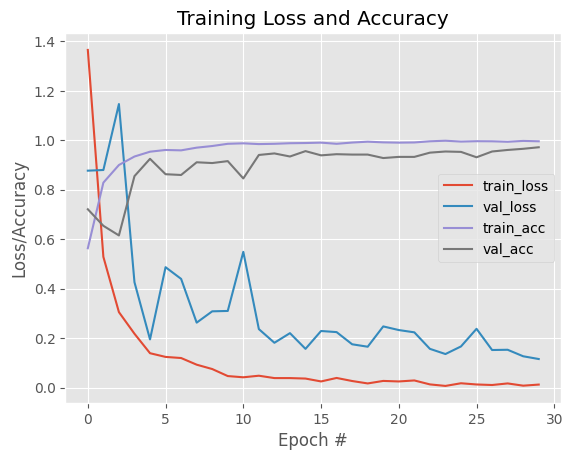

In [6]:
# Load the best weights
# Load the best weights
model.load_weights('/kaggle/working/model.weights.h5')


# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("parallelCNN_Model")

# Determine number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

In [7]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

Test loss: 0.13327573239803314
Test accuracy: 0.9691876769065857


In [8]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

report = classification_report(y_test_labels, y_pred)
print(report)

12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step 
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        74
           1       0.92      1.00      0.96        70
           2       0.98      0.93      0.95        57
           3       0.96      1.00      0.98        48
           4       0.98      1.00      0.99        56
           5       1.00      0.92      0.96        52

    accuracy                           0.97       357
   macro avg       0.97      0.97      0.97       357
weighted avg       0.97      0.97      0.97       357



In [10]:
from sklearn.metrics import classification_report

# Define class labels
# Define class labels
class_labels = ['Cardboard', 'Glass', 'Paper', 'Trash', 'Metal', 'Plastic']
# Make predictions on the test set

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

# Generate a classification report with specified target names
report = classification_report(y_test_labels, y_pred, target_names=class_labels)
print(report)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
              precision    recall  f1-score   support

   Cardboard       0.99      0.96      0.97        74
       Glass       0.92      1.00      0.96        70
       Paper       0.98      0.93      0.95        57
       Trash       0.96      1.00      0.98        48
       Metal       0.98      1.00      0.99        56
     Plastic       1.00      0.92      0.96        52

    accuracy                           0.97       357
   macro avg       0.97      0.97      0.97       357
weighted avg       0.97      0.97      0.97       357



Number of epochs trained: 30


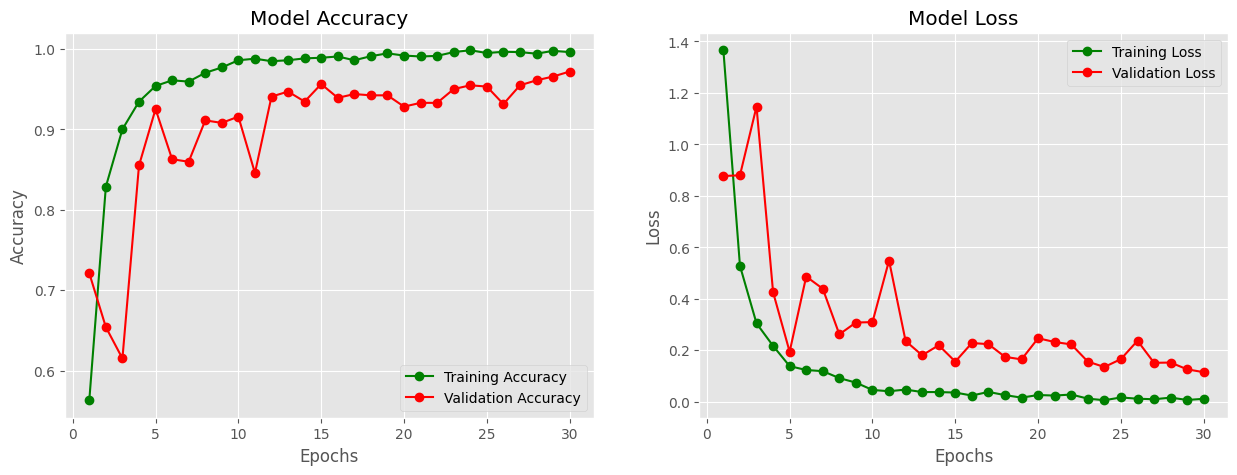

In [11]:
# Determine number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

# History plotting
epochs = range(1, num_epochs_trained + 1)
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15, 5)

# Plotting accuracy
ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Plotting loss
ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

# Save the figure as a PDF
plt.savefig('training_plot.pdf', format='pdf')

# Show the plot
plt.show()


Number of epochs trained: 30


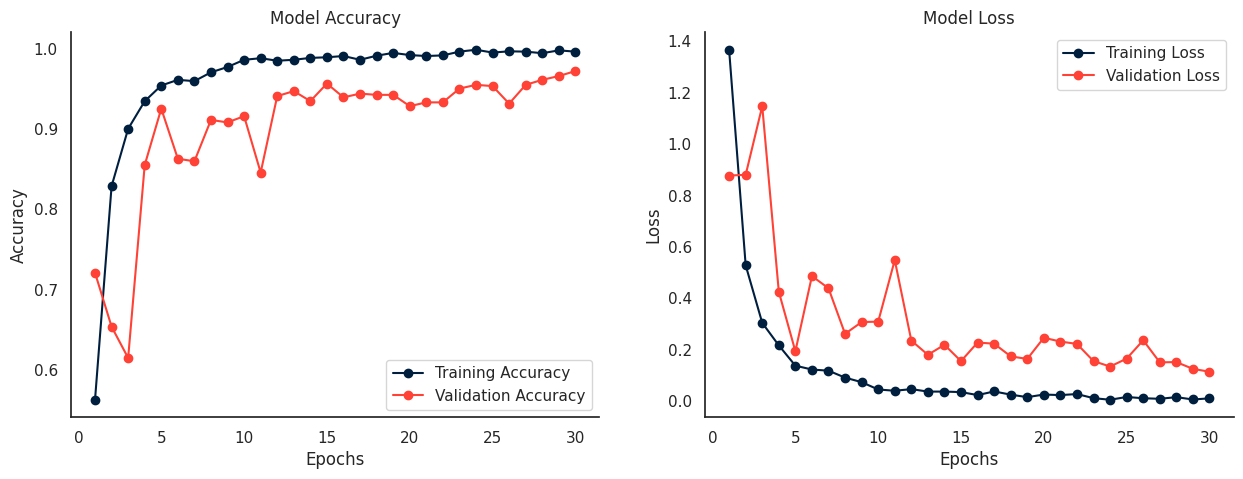

In [12]:
import seaborn as sns
# Set a seaborn style without grid lines
sns.set(style="white", rc={"axes.grid": False})

# Determine the number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

# Define custom colors
training_color = '#001f3f'  # dark blue color
validation_color = '#FF4136'  # dark red color

# Plotting training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plotting accuracy
axes[0].plot(range(1, num_epochs_trained + 1), history.history['accuracy'], 'o-', color=training_color, label='Training Accuracy')
axes[0].plot(range(1, num_epochs_trained + 1), history.history['val_accuracy'], 'o-', color=validation_color, label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")

# Plotting loss
axes[1].plot(range(1, num_epochs_trained + 1), history.history['loss'], 'o-', color=training_color, label='Training Loss')
axes[1].plot(range(1, num_epochs_trained + 1), history.history['val_loss'], 'o-', color=validation_color, label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")

# Beautify the plots
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Save the figure as a PDF
plt.savefig('journal_training_plot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


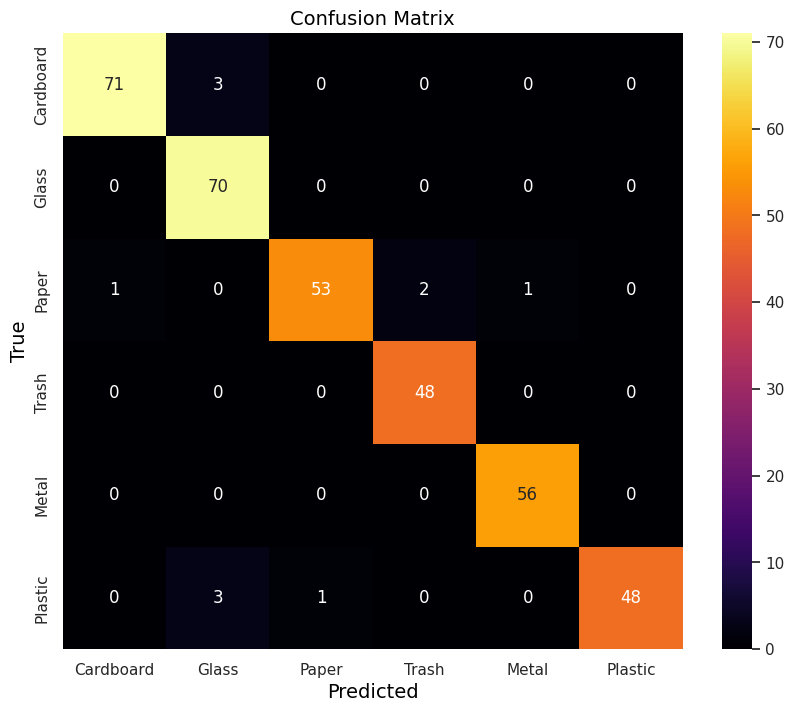

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ...

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get class labels in the desired order
#class_labels = ['Metal', 'White Glass', 'Biological', 'Paper', 'Brown Glass', 'Battery', 'Trash', 'Cardboard', 'Shoes', 'Clothes', 'Plastic', 'Green Glass']
# Define class labels
class_labels = ['Cardboard', 'Glass', 'Paper', 'Trash', 'Metal', 'Plastic']
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='inferno',xticklabels=class_labels, yticklabels=class_labels)

# Customize the font properties for labels and title
title_font = {'fontname': 'Times New Roman', 'size': '14', 'color': 'black', 'weight': 'normal'}
plt.xlabel('Predicted', **title_font)
plt.ylabel('True', **title_font)
plt.title('Confusion Matrix', **title_font)

# Save the confusion matrix plot as a PDF file
plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [14]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

# Evaluate the model on the test set
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate Matthews correlation coefficient
mcc = matthews_corrcoef(y_true, y_pred_classes)
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

# Calculate Cohen's kappa score
kappa = cohen_kappa_score(y_true, y_pred_classes)
print(f'Cohen\'s Kappa Score: {kappa:.4f}')


Matthews Correlation Coefficient (MCC): 0.9631
Cohen's Kappa Score: 0.9628


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate overall metrics
overall_accuracy = accuracy_score(y_true, y_pred_classes)
overall_precision = precision_score(y_true, y_pred_classes, average='weighted')
overall_recall = recall_score(y_true, y_pred_classes, average='weighted')
overall_f1_score = f1_score(y_true, y_pred_classes, average='weighted')

# Calculate specificity
overall_specificity = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

# Print overall metrics
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'Overall Precision: {overall_precision:.4f}')
print(f'Overall Recall: {overall_recall:.4f}')
print(f'Overall Specificity: {overall_specificity:.4f}')
print(f'Overall F1 Score: {overall_f1_score:.4f}')


Overall Accuracy: 0.9692
Overall Precision: 0.9706
Overall Recall: 0.9692
Overall Specificity: 0.9692
Overall F1 Score: 0.9691


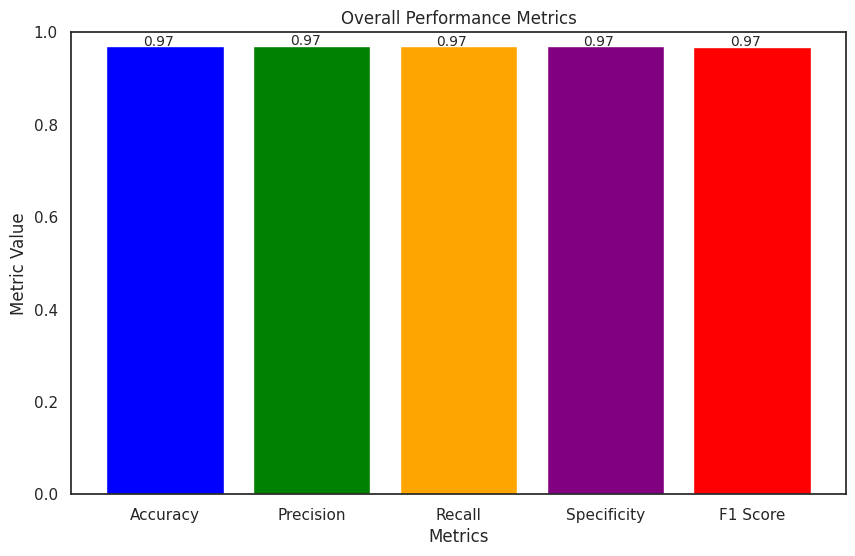

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate overall metrics
overall_accuracy = accuracy_score(y_true, y_pred_classes)
overall_precision = precision_score(y_true, y_pred_classes, average='weighted')
overall_recall = recall_score(y_true, y_pred_classes, average='weighted')
overall_f1_score = f1_score(y_true, y_pred_classes, average='weighted')

# Calculate specificity
overall_specificity = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

# Plotting
metrics_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
metrics_values = [overall_accuracy, overall_precision, overall_recall, overall_specificity, overall_f1_score]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'purple', 'red'])

# Add values above the bars
for bar, value in zip(bars, metrics_values):
    ax.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.002, f'{value:.2f}', fontsize=10)

# Set plot title and labels
plt.title('Overall Performance Metrics')
plt.ylabel('Metric Value')
plt.ylim([0, 1])  # Adjust the y-axis limits if necessary

# Add x-axis title
plt.xlabel('Metrics')

# Save the plot as a PDF file
plt.savefig('overall_metrics_plot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()




In [17]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # GPU index 0
power_usage = pynvml.nvmlDeviceGetPowerUsage(handle) / 1000  # Power usage in watts
print(f"Power consumption: {power_usage} W")


Power consumption: 33.152 W


In [19]:
!pip install codecarbon
from codecarbon import EmissionsTracker

tracker = EmissionsTracker()
tracker.start()

# Your training code here

tracker.stop()


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.9/502.9 kB 10.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.4/386.4 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: prompt_toolkit
    Found existing installation: prompt_toolkit 3.0.47
    Uninstalling prompt_toolkit-3.0.47:
      Successfully uninstalled prompt_toolkit-3.0.47
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 8.21.0 requires prompt-toolkit<3.1.0,>=3.0.41, but you have prompt-toolkit 3.0.36 which is incompatible.


[codecarbon INFO @ 07:49:36] [setup] RAM Tracking...
[codecarbon INFO @ 07:49:36] [setup] GPU Tracking...
[codecarbon INFO @ 07:49:36] Tracking Nvidia GPU via pynvml
[codecarbon WARNING @ 07:49:36] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
  File "/opt/conda/lib/python3.10/site-packages/pynvml/nvml.py", line 2039, in nvmlDeviceGetTotalEnergyConsumption
    _nvmlCheckReturn(ret)
  File "/opt/conda/lib/python3.10/site-packages/pynvml/nvml.py", line 765, in _nvmlCheckReturn
    raise NVMLError(ret)
pynvml.nvml.NVMLError_NotSupported: Not Supported
[codecarbon INFO @ 07:49:36] [setup] CPU Tracking...
[codecarbon WARNING @ 07:49:36] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\in

2.0405857366580787e-08

IndentationError: expected an indented block after function definition on line 6 (1966724138.py, line 9)